In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import interpolate
from scipy import integrate
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
#radiation constant in GJ/keV^4/cm^3
a = 0.01372
#speed of light in cm/sh; 1 sh is 10^-8 s
c = 299.98
Planck_int_const = 15*a*c/(4*math.pi**5)


def RHS(Tvect,t,Nx,dx,tau,sigma,Cve,Cvi,Tl):
    Te = Tvect[0:Nx]
    Ti = Tvect[Nx:]
    
    idx2 = 1.0/dx/dx
    TeNew = Te*0
    TiNew = Ti*0
    for i in range(Nx):
        if (i>0) and (i<Nx-1):
            kappa_l = sigma(t,(Te[i-1]+Te[i])*0.5)
            kappa_r = sigma(t,(Te[i+1]+Te[i])*0.5)
            itau = tau(t,Te[i],Ti[i])
            #we assume that the form of the opacity is the same
            #so we do not need to do the harmonic mean trick
            D_l = a*c/(3.0*kappa_l)
            D_r = a*c/(3.0*kappa_r)
            TeNew[i] =  1.0/Cve(t,Te[i])*(D_r*idx2*(Te[i+1]**4-Te[i]**4) - D_l*idx2*(Te[i]**4-Te[i-1]**4)+ 
                                        + itau*(Ti[i]-Te[i]))
        elif (i==0):
            kappa_l = sigma(t,0.5*(Tl+Te[i]))
            kappa_r = sigma(t,(Te[i+1]+Te[i])*0.5)
            itau = tau(t,Te[i],Ti[i])
            #Temperature on other side of boundary is Tl
            D_l = a*c/(3.0*kappa_l)
            D_r = a*c/(3.0*kappa_r)
            TeNew[i] =  1.0/Cve(t,Te[i])*(D_r*idx2*(Te[i+1]**4-Te[i]**4) - D_l*idx2*(Te[i]**4-Tl**4)+ 
                                        + itau*(Ti[i]-Te[i]))
        elif (i==Nx-1):
            kappa_l = sigma(t,(Te[i-1]+Te[i])*0.5)
            itau = tau(t,Te[i],Ti[i])
            #Reflecting boundary so that the derivative goes to zero
            D_l = c/(3.0*kappa_l)
            TeNew[i] =  1.0/Cve(t,Te[i])*( - D_l*idx2*(Te[i]**4-Te[i-1]**4)+ 
                                         + itau*(Ti[i]-Te[i]))
        TiNew[i] =  1.0/Cvi(t,Ti[i])*itau*(Te[i]-Ti[i])
    Tfinal = np.zeros(Nx*2)
    Tfinal[0:Nx] = TeNew.copy()
    Tfinal[Nx:] = TiNew.copy()
    return Tfinal

In [13]:
#set up initial conditions
Lx = 0.15
Nx = 200
dx = Lx/Nx
xval = np.linspace(dx/2,Lx-dx/2,Nx)
Te_init = np.zeros(Nx) + 1e-12
Ti_init = np.zeros(Nx) + 1e-12
Tfull_init = np.zeros(Nx*2)
Tfull_init[0:Nx] = Te_init.copy()
Tfull_init[Nx:] = Ti_init.copy()

sigma = lambda t, Te: 300*Te**-3
g0 = 1.0
tau = lambda t, Te,Ti: g0*0.5/(t+1.0e-14)
rho = 3.0
Cve = lambda t,Te: 0.1*rho
Cvi = lambda t,Ti: 0.05*rho
Tl = 1.0
RHS_lam = lambda t,Tvect: RHS(Tvect,t,Nx,dx,tau,sigma,Cve,Cvi,Tl)

In [14]:
sol = integrate.solve_ivp(RHS_lam, (0,1), Tfull_init, 
                                         method='BDF', max_step = 1e-3)

/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/bdf.py:403: RuntimeWarning: invalid value encountered in subtract
  D[order + 2] = d - D[order + 1]


(0, 0.2)

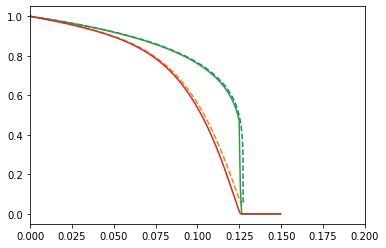

In [15]:
#plt.plot(sol.y[0,0:Nx])
#bench=np.genfromtxt('marshak_1sh.csv', delimiter=',')[1:,:]
bench = np.loadtxt('g1.csv', delimiter=",")
plt.plot(bench[:,0],bench[:,1],'--')
plt.plot(bench[:,0],bench[:,2],'--')
plt.plot(xval,sol.y[0:Nx,-1])
plt.plot(xval,sol.y[Nx:,-1])
plt.xlim(0,0.2)

In [11]:
print(xval[(xval>0.124)*(xval<0.13)],sol.y[0:Nx,-1][(xval>0.124)*(xval<0.13)])

[0.12525 0.12675 0.12825 0.12975] [1.64542433e-02 1.14620228e-12 1.00000000e-12 1.00000000e-12]
